# Car brand classification report

## Summary

1. [Introduction](#introduction)
2. [Data analysis](#dataanalysis)
    1. [Exploring the subject](#2.1)
    2. [Generating the dataset](#2.2)
    3. [Data exploration & analysis](#2.3)
3. [Data preprocessing](#datapreprocessing)
    1. [Load data](#3.1)
    2. [Normalization & reshape](#3.2)
    3. [Label encoding](#3.3)
    4. [Split train & validation set](#3.4)
4. First neural network training
    1. Linear classification
    2. Multi Layer Pereceptron
    3. Support Vector Machine
5. Improve the neural network
    1. Data augmentation
    2. Intuitions
6. Prediction & submissions
    1. Predict & submit results
7. Conclusion

<a id="introduction"></a>

<a id="introduction"></a>
## 1. Introduction

This report aims to explain how te evaluate various model for a same problematic : **Car brand prediction with an image dataset**.
We'll be exploring various models and training various one te interpret which one is the most accurate. Then we'll explain intuition that led us to several way to imrove data and therefore the **model**.

The best model we manage to produce had an **A FAIRE** accuracy.

This notebook contains three four part:
* Data analysis
* Data preprocessing
* First neural networks training and evaluation
* Neural network and data improvement


<a id="dataanalysis"></a>
## 2. Data analysis

This part will describe how the data was scrapped and generated and also will be explored to know the repartition of each car brand in the dataset.

<a id="2.1"></a>
### 2.1 Exploring the subject

**First approach**
First of all, in order to retrieve numerous images of a car from a specific brand we decide to create a bot to scrap google images with search such as 'audi front' or 'mercedes'.

The results were not good with too many unrevelant photos and bad quality:

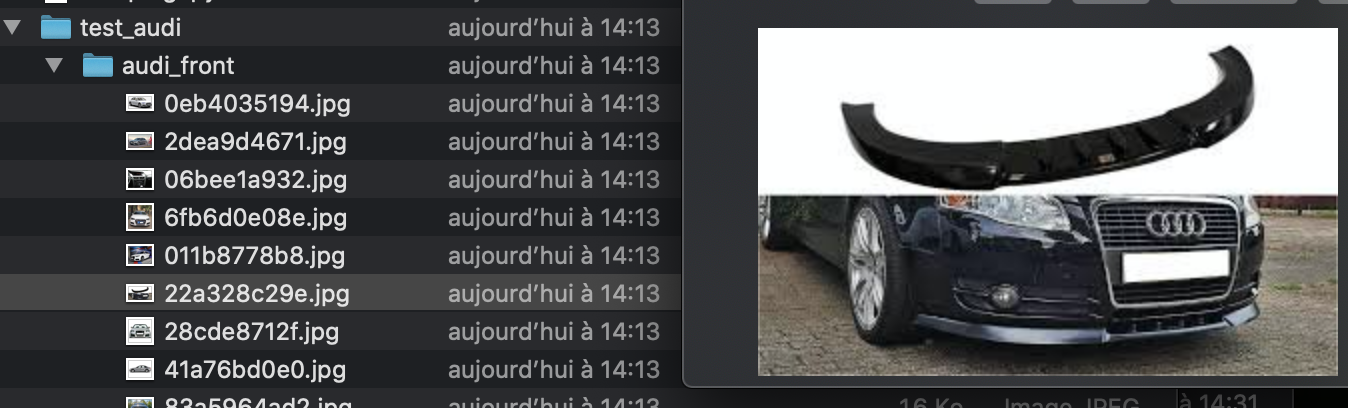

In [ ]:
#
# Firstly we import necessary libs
#
import selenium
import os
import io
import time
import requests
import hashlib
from PIL import Image
from selenium import webdriver
DRIVER_PATH = '/Users/Damien/Documents/chromedriver' # Chromedriver path required


#
# Fetch all images url's from a specific gogole search
#

def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

#
# Utility function to save images form url in a folder
#

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
        
#
# Combine fetch url and save image utility functions into a more practical to use function
#

def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=5):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)

# Example of usage => search_and_download('audi front', DRIVER_PATH, './dataset', 60)

<a id="2.2"></a>
### 2.2 Generating the dataset

**Second approach**

From then on we wanted to base ourselves on the images of the car ad site.
By dint of searching we found the site carizy.com which offered a strong formalised layout for pictures.
By studying the site we found that the photos were hosted on a CDN with a formalised structure for each angle (front hood).
So we set up a script to retrieve quality images on the brands we wanted with the right angle. By doing so we could iterate over brands and also over angles of the car.

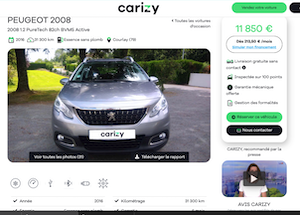

In [ ]:
#
# Import necessary dependencies
#
import time
import requests
import os
import io
from PIL import Image
import hashlib

#
# Define a car data class that retrieve the useful data
#

class CarData:
    def __init__(self, car_id, url, img):
        self.car_id = car_id
        self.url = url
        self.img = img
        
    def __repr__(self):
        return str(self.car_id) + " : " + self.url + ' + ' + self.img
    
#
# Request the search api of the website with good params
#

def send_algolia_request(page):
    url = 'https://65quub6n61-dsn.algolia.net/1/indexes/*/queries?x-algolia-agent=Algolia%20for%20vanilla%20JavaScript%20(lite)%203.18.1%3Binstantsearch.js%201.8.11&x-algolia-application-id=65QUUB6N61&x-algolia-api-key=9ce4fd3eb414de32d0985b9b5a394448'
    data = {'requests': [{'indexName' : 'CarAlgoliaIndex_prod', 'params': 'query=&hitsPerPage=21&maxValuesPerFacet=100&page='+ str(page) +'&facets=%5B%22make%22%2C%22model%22%2C%22body%22%2C%22registartionDate%22%2C%22color%22%2C%22gear%22%2C%22fuel%22%2C%22price%22%2C%22monthly%22%2C%22kilometers%22%2C%22district%22%2C%22districtName%22%2C%22city%22%2C%22seats%22%2C%22isScrapPremium%22%5D&tagFilters='}]}
    p = requests.post(url, json=data)
    return p.json()

#
# map data to keep only useful data
#

def map_data(_car_data, hits):
    for e in hits:
        if e['make'] in _car_data:
            _car_data[e['make']].append(CarData(e['carId'], e['lien'], e['photo']))
        else:
            _car_data[e['make']] = [CarData(e['carId'], e['lien'], e['photo'])]

#
# Make all the request with a interval to avoid api blocking
#            
            
car_data = {}
i = 0
while i < 48:
    x = send_algolia_request(i)
    map_data(car_data, x['results'][0]['hits'])
    i += 1
    time.sleep(1)
   


#
# Utility function to download the images
#

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
 
#
# Final function that takes brand and angle paramaters
#

def download_brand_angle_img(brand, angle):
    urls = []
    for x in car_data[brand]:
        
        ur = x.img.replace('avant-gauche', angle)
        finalurl = 'https://cdn.carizy.com/carphotos/' + str(x.car_id) + '/wide/' + ur
        urls.append(finalurl)
    
    #folder_url = '/' + brand + '/' + angle
    folder_url = './cars'
    for z in urls:
        persist_image(folder_url, z)
        time.sleep(1)

#Example of usage => download_brand_angle_img('AUDI', 'face-capot')


<a id="2.3"></a>
### 2.3 Data exploration & analysis